Within this notebook we will look at an example Regression problem. We will try to predict "nihtbx_picvocab_agecorrected" scores.

# Init Phase

In [1]:
import ABCD_ML

In [2]:
# We will use the default nda dr for this
nda_dr = '/mnt/sdb2/ABCD2p0NDA/'

# We will use the gordon ROI resting state fMRI correlations as our data
data_loc = nda_dr + 'abcd_betnet02.txt'

# This file contains the NIH toolbox scores
target_loc = nda_dr + 'abcd_tbss01.txt'

# For exclusions we will excluse the flipped subjects
exclusion_loc = '/home/sage/bader_things/invalid_pguids.txt'

In [3]:
ML = ABCD_ML.ABCD_ML()

ABCD_ML object initialized


# Data Loading Phase

We will start by loading exclusions, the reason for this is, if loaded before data or covars, ect... the excluded subjects will be removed when loading data, targets, ect... as loaded before any drop behavior based on values. For example, when computing different filter_outliers, or dropping columns ect... this way it will only consider the non-excluded subjects. If instead it doesn't matter, then exclusions can be loaded later, and just will be retro-actively applied. 

In [4]:
ML.Load_Exclusions(loc = exclusion_loc)

Total excluded subjects:  1137
Removed excluded subjects from loaded dfs


In [5]:
ML.Load_Data(loc = data_loc)

Loading /mnt/sdb2/ABCD2p0NDA/abcd_betnet02.txt assumed to be dataset type: basic
dropped ['collection_id', 'abcd_betnet02_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'gender', 'rsfmri_c_ngd_visitid', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type
Dropped 0 columns, per drop_keys argument
Dropped 0 cols for all missing values
Dropped 604 rows for missing values
Dropped rows with missing data
loaded shape:  (9295, 181)

The following columns have a questionable number of unique values: 
rsfmri_c_ngd_tr unique vals: 10
rsfmri_c_ngd_numtrs unique vals: 117
rsfmri_c_ngd_nvols unique vals: 104
rsfmri_c_ngd_stnvols unique vals: 1257
rsfmri_c_ngd_stcontignvols unique vals: 1354
rsfmri_c_ngd_ntpoints unique vals: 1403


Total valid overlapping subjects = 9295



Lets take a quick look at the data, especially since we have a number of warning columns with not a lot of unique values. This is an indicator that thew column might not be wanted as data is supposed to be neuroimaging data.

In [6]:
ML.data.head()

,rsfmri_c_ngd_tr,rsfmri_c_ngd_numtrs,rsfmri_c_ngd_nvols,rsfmri_c_ngd_stnvols,rsfmri_c_ngd_stcontignvols,rsfmri_c_ngd_ntpoints,rsfmri_c_ngd_meanmotion,rsfmri_c_ngd_maxmotion,rsfmri_c_ngd_meantrans,rsfmri_c_ngd_maxtrans,...,rsfmri_c_ngd_vs_ngd_dt,rsfmri_c_ngd_vs_ngd_dla,rsfmri_c_ngd_vs_ngd_fo,rsfmri_c_ngd_vs_ngd_n,rsfmri_c_ngd_vs_ngd_rspltp,rsfmri_c_ngd_vs_ngd_smh,rsfmri_c_ngd_vs_ngd_smm,rsfmri_c_ngd_vs_ngd_sa,rsfmri_c_ngd_vs_ngd_vta,rsfmri_c_ngd_vs_ngd_vs
src_subject_id,,,,,,,,,,,,,,,,,,,,,
NDAR_INV003RTV85,0.8,1532,1500,1162.0,1066.0,1023.0,0.154780,2.015052,0.105427,0.850991,...,-0.091892,0.108123,-0.046754,-0.038999,0.263348,-0.019762,0.055314,-0.094447,-0.210556,0.391807
NDAR_INV00J52GPG,0.8,1532,1500,1127.0,896.0,819.0,0.164131,1.224842,0.122374,0.865260,...,-0.072341,0.000464,-0.018576,-0.027246,0.025676,-0.069841,-0.005953,0.012106,-0.031176,0.189339
NDAR_INV00LH735Y,0.8,1532,1500,1469.0,1449.0,1431.0,0.075550,0.341670,0.061237,0.268401,...,-0.162628,0.037883,-0.164983,-0.049898,0.263128,0.028018,0.175882,-0.093186,-0.107731,0.534284
NDAR_INV019DXLU4,0.8,1532,1500,519.0,299.0,163.0,0.561580,6.686306,0.324974,4.172889,...,-0.224160,-0.003807,-0.165525,-0.029099,0.103379,0.072112,0.002704,-0.048668,-0.118902,0.452859
NDAR_INV01TXCDJN,0.8,1532,1500,514.0,340.0,162.0,0.767780,11.729949,0.364528,4.149230,...,-0.097067,0.176931,-0.030358,-0.064213,0.183397,0.024869,0.172476,-0.329215,-0.093264,0.357987


Alright, the obvious problem is that we have a number of columns that we most likely dont want to include. Specifically, there are a number of descriptors, like number of trials, which we don't want. We just want to grab the correlations.
Let's clear the data and reload it, explicitly telling the data loader to drop those keys.

In [7]:
to_drop = list(ML.data)[:12]
to_drop

['rsfmri_c_ngd_tr',
 'rsfmri_c_ngd_numtrs',
 'rsfmri_c_ngd_nvols',
 'rsfmri_c_ngd_stnvols',
 'rsfmri_c_ngd_stcontignvols',
 'rsfmri_c_ngd_ntpoints',
 'rsfmri_c_ngd_meanmotion',
 'rsfmri_c_ngd_maxmotion',
 'rsfmri_c_ngd_meantrans',
 'rsfmri_c_ngd_maxtrans',
 'rsfmri_c_ngd_meanrot',
 'rsfmri_c_ngd_maxrot']

In [8]:
ML.Clear_Data()
ML.Load_Data(loc = data_loc, drop_keys=to_drop)

cleared data.
Loading /mnt/sdb2/ABCD2p0NDA/abcd_betnet02.txt assumed to be dataset type: basic
dropped ['collection_id', 'abcd_betnet02_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'gender', 'rsfmri_c_ngd_visitid', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type
Dropped 12 columns, per drop_keys argument
Dropped 0 cols for all missing values
Dropped 550 rows for missing values
Dropped rows with missing data
loaded shape:  (9349, 169)

Total valid overlapping subjects = 9349



In [9]:
ML.data.head()

,rsfmri_c_ngd_ad_ngd_ad,rsfmri_c_ngd_ad_ngd_cgc,rsfmri_c_ngd_ad_ngd_ca,rsfmri_c_ngd_ad_ngd_dt,rsfmri_c_ngd_ad_ngd_dla,rsfmri_c_ngd_ad_ngd_fo,rsfmri_c_ngd_ad_ngd_n,rsfmri_c_ngd_ad_ngd_rspltp,rsfmri_c_ngd_ad_ngd_smh,rsfmri_c_ngd_ad_ngd_smm,...,rsfmri_c_ngd_vs_ngd_dt,rsfmri_c_ngd_vs_ngd_dla,rsfmri_c_ngd_vs_ngd_fo,rsfmri_c_ngd_vs_ngd_n,rsfmri_c_ngd_vs_ngd_rspltp,rsfmri_c_ngd_vs_ngd_smh,rsfmri_c_ngd_vs_ngd_smm,rsfmri_c_ngd_vs_ngd_sa,rsfmri_c_ngd_vs_ngd_vta,rsfmri_c_ngd_vs_ngd_vs
src_subject_id,,,,,,,,,,,,,,,,,,,,,
NDAR_INV003RTV85,0.420664,0.214043,-0.133798,-0.084748,-0.001194,-0.049960,-0.039415,-0.086807,0.156841,0.216998,...,-0.091892,0.108123,-0.046754,-0.038999,0.263348,-0.019762,0.055314,-0.094447,-0.210556,0.391807
NDAR_INV00J52GPG,0.234350,0.184643,-0.156042,-0.077856,-0.012531,-0.063291,-0.002182,-0.061186,0.121436,0.165561,...,-0.072341,0.000464,-0.018576,-0.027246,0.025676,-0.069841,-0.005953,0.012106,-0.031176,0.189339
NDAR_INV00LH735Y,0.414891,0.086734,-0.160336,-0.062129,-0.056566,-0.109059,0.015876,0.025512,0.246414,0.240989,...,-0.162628,0.037883,-0.164983,-0.049898,0.263128,0.028018,0.175882,-0.093186,-0.107731,0.534284
NDAR_INV019DXLU4,0.086191,0.095968,-0.080095,-0.039539,0.036697,0.047779,-0.007446,-0.079431,0.035770,0.034503,...,-0.224160,-0.003807,-0.165525,-0.029099,0.103379,0.072112,0.002704,-0.048668,-0.118902,0.452859
NDAR_INV01TXCDJN,0.349332,0.084691,-0.334724,-0.051178,-0.021056,0.067937,0.019556,-0.077872,0.175119,0.376639,...,-0.097067,0.176931,-0.030358,-0.064213,0.183397,0.024869,0.172476,-0.329215,-0.093264,0.357987


Great, looks better, though the correlations have an extra problem. That is namely, there are repeat columns as X corr with y, and y corr with x. Not, Load_Data has a function to remove duplicate columns (marked as duplicate if they above a user defined correlation threshold with another column). Instead of reloading the data though, we can also call a specific function for this purpose.

In [10]:
ML.Drop_Data_Duplicates(corr_thresh=.99)

Dropped 78 columns as duplicate cols!


Okay, now we lets load our targets, and for covars just age + sex and our exclusions.

In [11]:
ML.Load_Targets(target_loc, 'nihtbx_picvocab_agecorrected', 'float')

ML.Load_Covars(data_loc, ['interview_age', 'gender'], ['f', 'b'])

Loading targets!
Loading /mnt/sdb2/ABCD2p0NDA/abcd_tbss01.txt assumed to be dataset type: basic
Final shape:  (10604, 1)

Total valid overlapping subjects = 9231

Loading covariates!
Loading /mnt/sdb2/ABCD2p0NDA/abcd_betnet02.txt assumed to be dataset type: basic
load: interview_age
load: gender

Total valid overlapping subjects = 9229



            targets
count  10604.000000
mean     106.858072
std       17.049005
min        0.000000
25%       98.000000
50%      106.000000
75%      120.000000
max      208.000000

Num. of unique vals: 59


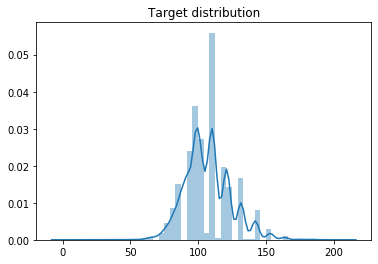

In [12]:
ML.Show_Targets_Dist()

It appears that there are some severe outliers... lets try reloading targets and just cut off the top 1% from either side of the distribution and see if that helps. Note: what we are doing here is acting upon the whole dataset before any train/test split, therefore it is reccomended that at this stage any global actions should be reasonable... in this case it seems reasonable to remove subjects with scores that are likely just human input error.

In [13]:
ML.Load_Targets(target_loc, 'nihtbx_picvocab_agecorrected', 'float', filter_outlier_percent=1)

Loading targets!
Loading /mnt/sdb2/ABCD2p0NDA/abcd_tbss01.txt assumed to be dataset type: basic
Filtering for outliers, dropping rows with params:  1
Min-Max Score (before outlier filtering): 0.0 208.0
Min-Max Score (post outlier filtering): 77.0 152.0
Final shape:  (10262, 1)

Total valid overlapping subjects = 8937



            targets
count  10262.000000
mean     106.475346
std       14.929790
min       77.000000
25%       98.000000
50%      106.000000
75%      120.000000
max      152.000000

Num. of unique vals: 34


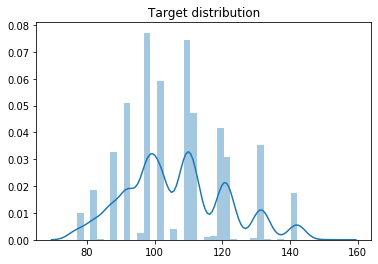

In [14]:
ML.Show_Targets_Dist()

One percent might even be too much...

In [15]:
ML.Load_Targets(target_loc, 'nihtbx_picvocab_agecorrected', 'float', filter_outlier_percent=.005)

Loading targets!
Loading /mnt/sdb2/ABCD2p0NDA/abcd_tbss01.txt assumed to be dataset type: basic
Filtering for outliers, dropping rows with params:  0.005
Min-Max Score (before outlier filtering): 0.0 208.0
Min-Max Score (post outlier filtering): 71.0 155.0
Final shape:  (10466, 1)

Total valid overlapping subjects = 9116



            targets
count  10466.000000
mean     106.755398
std       15.910384
min       71.000000
25%       98.000000
50%      106.000000
75%      120.000000
max      155.000000

Num. of unique vals: 38


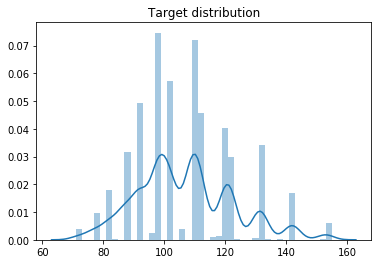

In [16]:
ML.Show_Targets_Dist()

That looks a little better, so only the really severe outliers are removed. The distribution is still a bit weird, but nothing we can do about that.

We have now loaded:
-Exclusions
-Data, Targets and Covars

We could optionally load stratification values, but for this example, we will just use random cross validation.

# Validation Phase

In [17]:
#We could optional define a validation strategy here, but we use default
ML.Train_Test_Split(test_size=.25, random_state=1)

Final data for modeling loaded shape: (9116, 94)
Performed train/test split, train size: 6837 test size:  2279


# Modeling Phase

In [18]:
ML.Set_Default_ML_Params(problem_type='regression',
                         metric=['r2', 'mse'],
                         data_scaler='standard',
                         n_splits=3,
                         n_repeats=2,
                         int_cv=3,
                         n_jobs=8,
                         n_iter=20,
                         random_state=1)

No default feat selector passed, set to None
No default extra params passed, set to empty dict
Default params set.



In [19]:
ML.Show_Models(problem_type='regression')

Note: gs and rs are  Grid Search and Random Search
Models with gs or rs will have their hyper-parameters tuned accordingly.

Problem Type: regression
----------------------
Avaliable models: 

Model str indicator:  elastic net
Model object:  <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>

Model str indicator:  elastic net rs
Model object:  <class 'sklearn.model_selection._search.RandomizedSearchCV'>

Model str indicator:  gp regressor
Model object:  <class 'sklearn.gaussian_process.gpr.GaussianProcessRegressor'>

Model str indicator:  knn regressor
Model object:  <class 'sklearn.neighbors.regression.KNeighborsRegressor'>

Model str indicator:  knn regressor gs
Model object:  <class 'sklearn.model_selection._search.GridSearchCV'>

Model str indicator:  lars cv
Model object:  <class 'sklearn.linear_model.least_angle.LarsCV'>

Model str indicator:  light gbm regressor
Model object:  <class 'lightgbm.sklearn.LGBMRegressor'>

Model str indicator:  light gbm regressor rs
Model 

In [20]:
raw_scores = ML.Evaluate(model_type = 'svm', feat_selector = 'univariate select half') 

Running Evaluate with:
model_type = svm
problem_type = regression
metric = ['r2', 'mse']
data_scaler = standard
feat_selector = univariate select half
n_splits = 3
n_repeats = 2
int_cv = 3
n_jobs = 8
n_iter = 20
random_state = 1
extra_params = {}


Metric:  r2
Mean score:  0.047002491777001595
Macro std in score:  0.0013698620863228754
Micro std in score:  0.00892679960692654

Metric:  mean squared error
Mean score:  -240.43305764300845
Macro std in score:  0.33981950652942317
Micro std in score:  9.150611530245017



Notably, when you provide multiple metrics/scorers, the first one in the list is used for model selection. Let's see if reversing the order and using mean squared error for model selection changes anything.

In [21]:
raw_scores = ML.Evaluate(model_type = 'svm rs', metric=['mse', 'r2'])

Running Evaluate with:
model_type = svm rs
problem_type = regression
metric = ['mse', 'r2']
data_scaler = None
feat_selector = None
n_splits = 3
n_repeats = 2
int_cv = 3
n_jobs = 8
n_iter = 20
random_state = 1
extra_params = {}



KeyboardInterrupt: 

In [ ]:
ML.Model.model